THÊM THƯ VIỆN

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import os
import glob
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

TIỀN XỬ LÝ DỮ LIỆU

In [ ]:
#Xuất dữ liệu
RAV = '/content/drive/MyDrive/Colab Notebooks/data CD/RAVDESS/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)

emotion = [] #biểu thị cảm xúc của âm thanh
gender = [] #giới tính của người nói
path = [] #đường dẫn đến file âm thanh tương ứng
feature = []
#Phân tích tên file âm thanh để trích xuất thông tin về cảm xúc và giới tính của người nói.
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

#Xây dựng DataFrame RAV_df từ các thông tin đã trích xuất
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
#Loại bỏ cột 'gender' và hiển thị số lượng mẫu dữ liệu cho mỗi nhãn cảm xúc.
RAV_df = RAV_df.drop(['gender'], axis=1)
RAV_df.labels.value_counts()

labels
female_neutral     144
male_neutral       144
female_happy        96
female_sad          96
female_surprise     96
female_disgust      96
female_fear         96
female_angry        96
male_fear           96
male_angry          96
male_sad            96
male_happy          96
male_surprise       96
male_disgust        96
Name: count, dtype: int64

In [ ]:
display(RAV_df.head()) #hiển thị các dòng đầu tiên của DataFrame RAV_df
display(RAV_df.describe()) # tóm tắt thống kê của các cột số trong DataFrame RAV_df

,emotion,labels,source,path
0,happy,female_happy,RAVDESS,/content/drive/MyDrive/Colab Notebooks/data CD...
1,happy,female_happy,RAVDESS,/content/drive/MyDrive/Colab Notebooks/data CD...
2,happy,female_happy,RAVDESS,/content/drive/MyDrive/Colab Notebooks/data CD...
3,happy,female_happy,RAVDESS,/content/drive/MyDrive/Colab Notebooks/data CD...
4,sad,female_sad,RAVDESS,/content/drive/MyDrive/Colab Notebooks/data CD...


,emotion,labels,source,path
count,1440,1440,1440,1440
unique,7,14,1,1440
top,neutral,female_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/data CD...
freq,288,144,1440,1


TRỰC QUAN HÓA DỮ LIỆU

In [ ]:
#Dùng histogram để vẽ biểu đồ miêu tả chung sự phân bố của các nhãn
px_fig = px.histogram(RAV_df, x='emotion', color='emotion', marginal='box', title='Emotion Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

#Dùng histogram để vẽ biểu đồ miêu tả chi tiết sự phân bố của các nhãn
px_fig = px.histogram(RAV_df, x='labels', color='emotion', marginal='box', title='Label Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

In [ ]:
# Tạo hàm hiển thị đồ thị sóng của giọng nói
# data: dữ liệu; sr : sampling rate; e : emotion
#sr là sampling rate là tần số lấy mẫu. Nó đo lường tần suất mẫu hóa dữ liệu âm thanh và được đo tính bằng Hz
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Biểu đồ sóng cho âm thanh có cảm xúc {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [ ]:
# Tạo hàm hiển thị đồ thị phổ quang của giọng nói
def create_spectrogram(data, sr, e):
    # Hàm stft chuyển đổi dữ liệu thành biến đổi Fourier ngắn hạn
    X = librosa.stft(data)
    # Chuyển âm thanh về decibel(dB)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Quang phổ cho âm thanh có cảm xúc {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

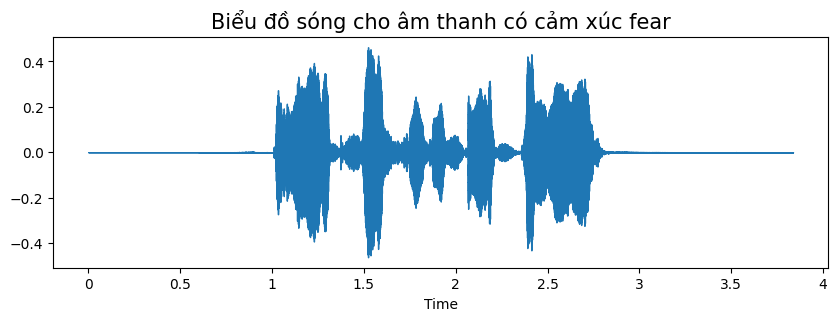

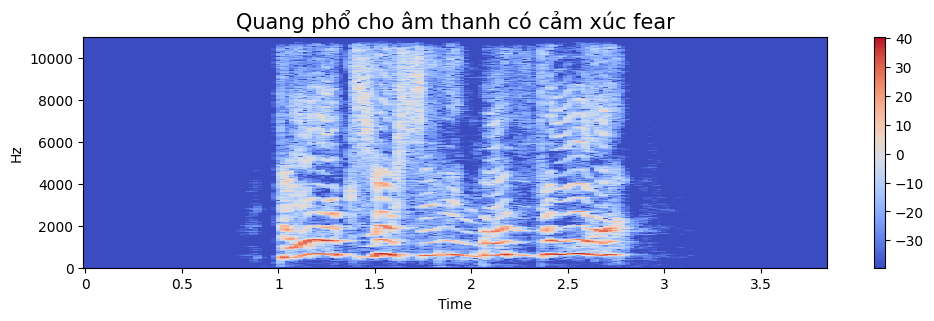

In [ ]:
# Hiển thị biểu đồ sóng và phổ quang miêu tả về âm thanh sợ hãi
emotion='fear'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path) # phát lại âm thanh từ đường dẫn đã chọn

TĂNG CƯỜNG DỮ LIỆU

In [ ]:
# Hàm làm nhiễu âm thanh
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Hàm kéo dài âm thanh
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

# Hàm chuyển dịch thời gian âm thanh : âm thanh sẽ bị chuyển dịch ngẫu nhiên
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

# Hàm thay đổi hiệu ứng âm thanh cao hoặc thấp
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(RAV_df.path)[1]
data, sample_rate = librosa.load(path)

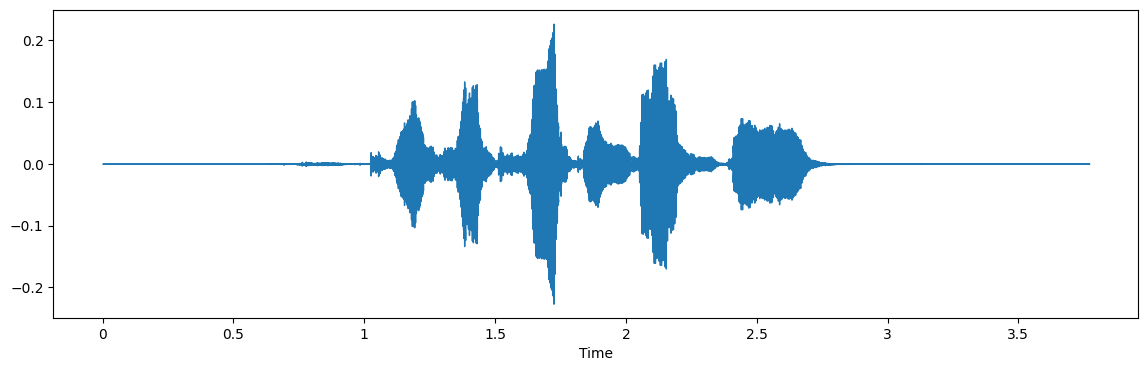

In [ ]:
# Âm thanh bình thường
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

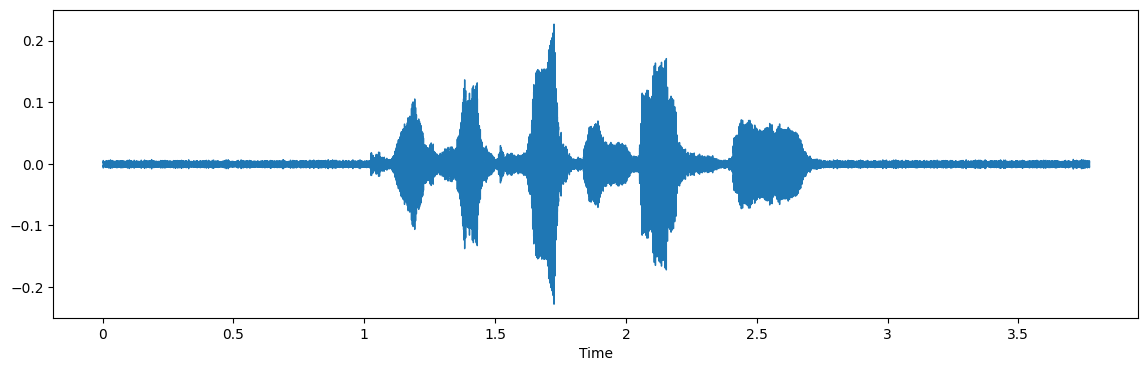

In [ ]:
# Âm thanh bị lãm nhiễu
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

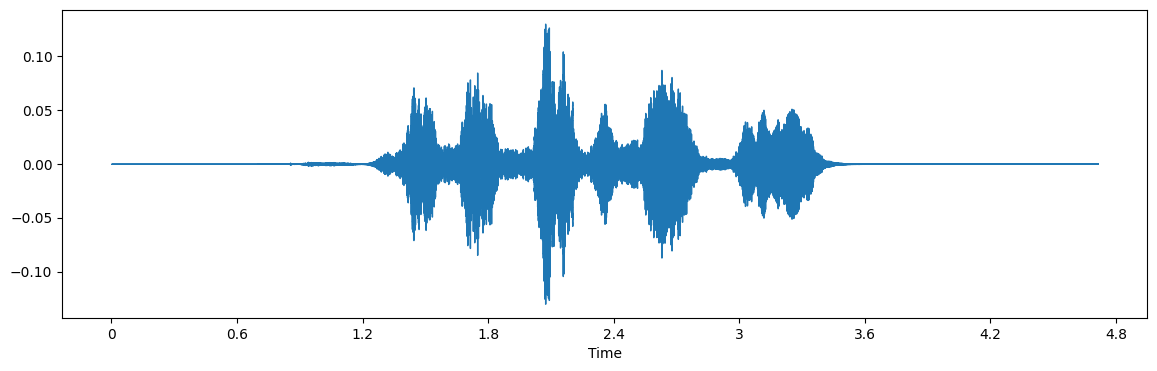

In [ ]:
# Âm thanh bị kéo dãn
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

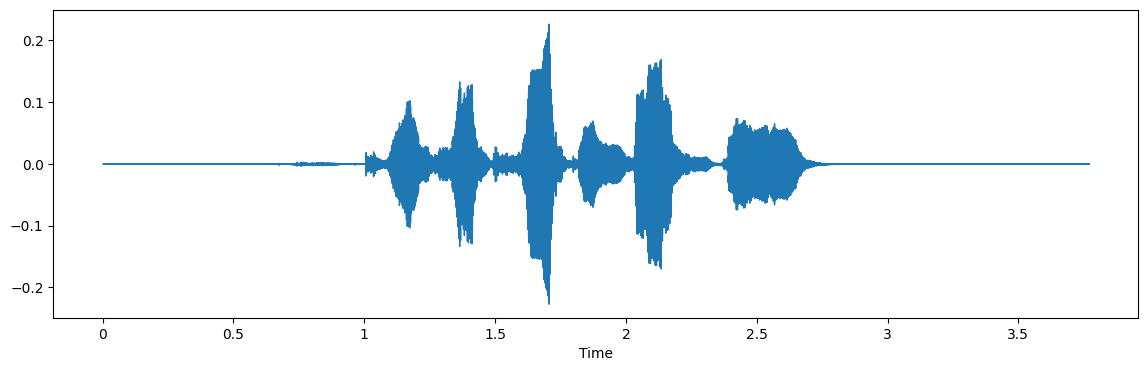

In [ ]:
# Âm thanh bị chuyển dịch
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

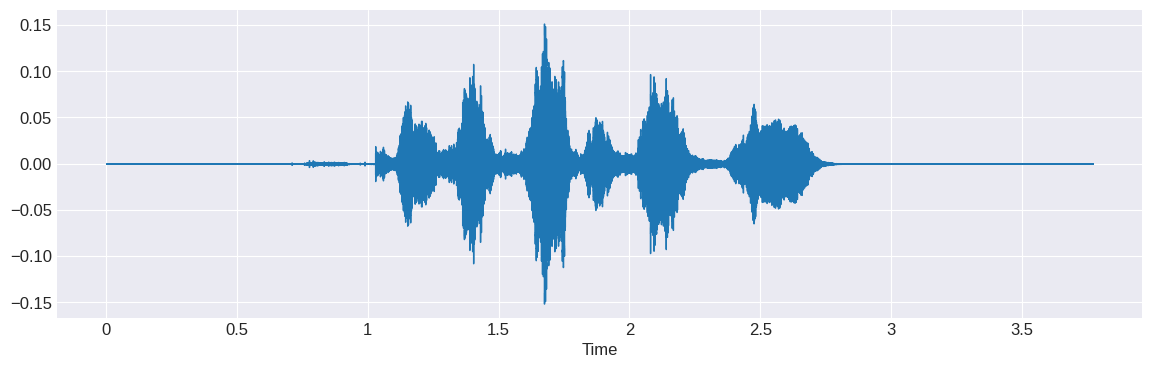

In [ ]:
# Âm thanh được nhấn mạnh
x = pitch(data,sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

KHAI THÁC TÍNH NĂNG

In [ ]:
# Hàm trích xuất các đặc trưng từ dữ liệu
def extract_features(data):
    # ZCR: Tần số băng qua không là tốc độ tín hiệu thay đổi từ dương sang 0 sang âm hoặc từ âm sang 0 sang dương
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft : Thể hiện phân bố tần số của các nốt nhạc trong tín hiệu âm thanh.
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC : Là một bộ các đặc trưng được sử dụng phổ biến trong xử lý tín hiệu âm thanh
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value: Là một đại lượng thể hiện sức mạnh trung bình của tín hiệu âm thanh trong mỗi cửa sổ thời gian
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram : là biểu diễn trực quan của phổ tần số của tín hiệu âm thanh,
    #trong đó các tần số được biểu diễn trên trục y dưới dạng các băng thông mel thay vì Hz.
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result
# Hàm trích xuất các đặc trưng từ dữ liệu âm thanh
def get_features(path):
    # Xử lý thời lượng và độ lệch được sử dụng để xử lý phần không có âm thanh khi bắt đầu và kết thúc của mỗi tệp âm thanh
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Với không tăng cường
    res1 = extract_features(data)
    result = np.array(res1)

    # làm nhiễu dữ liệu
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    # kéo dãn và nhấn mạnh/thấp của âm thanh
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))

    return result

In [ ]:
# Thêm cảm xúc 3 lần vì đã thực hiện 3 kỹ thuật
# tăng cường trên mỗi tệp âm thanh
X, Y = [], []
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
#mã trả về kích thước của X, Y và số lượng đường dẫn âm thanh trong RAV_df
len(X), len(Y), RAV_df.path.shape

(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [ ]:
#Hiển thị một số dòng đầu tiên và thống kê
display(Features.head())
display(Features.describe())

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.246469,0.599984,0.507379,0.547962,0.569861,0.483175,0.495233,0.544922,0.613930,0.632820,...,0.000450,0.000515,0.000357,0.000314,0.000294,0.000191,0.000119,0.000076,0.000004,happy
1,0.259187,0.675705,0.585034,0.566625,0.637623,0.583858,0.520569,0.540778,0.588882,0.664343,...,0.000473,0.000537,0.000372,0.000338,0.000314,0.000216,0.000140,0.000094,0.000025,happy
2,0.190357,0.579726,0.630485,0.507829,0.488429,0.568180,0.462877,0.430153,0.521295,0.545949,...,0.000149,0.000106,0.000096,0.000081,0.000076,0.000069,0.000073,0.000021,0.000001,happy
3,0.190127,0.674287,0.547792,0.506907,0.628658,0.549511,0.469703,0.524081,0.565292,0.628100,...,0.000326,0.000423,0.000286,0.000147,0.000113,0.000096,0.000116,0.000093,0.000014,happy
4,0.310533,0.776641,0.714047,0.654434,0.738910,0.749636,0.580966,0.564660,0.591010,0.643579,...,0.001658,0.001877,0.001598,0.001596,0.001439,0.001576,0.001550,0.001516,0.001417,happy


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,...,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03
mean,0.210636,0.627721,0.630928,0.635772,0.645914,0.635181,0.606422,0.600995,0.620078,0.637291,...,1.675297e-03,1.685580e-03,1.730813e-03,1.764678e-03,1.816031e-03,1.845277e-03,1.842009e-03,1.804642e-03,1.306146e-03,6.743750e-04
std,0.068571,0.088189,0.097436,0.100298,0.102284,0.104975,0.091573,0.078782,0.080572,0.079546,...,5.605010e-03,5.638796e-03,5.821698e-03,6.066933e-03,6.367134e-03,6.335372e-03,6.196535e-03,5.945670e-03,4.837875e-03,3.788022e-03
min,0.060091,0.339261,0.287325,0.274444,0.261164,0.263645,0.269483,0.262952,0.242572,0.269638,...,2.135293e-08,1.692828e-08,2.129181e-08,2.400353e-08,2.899570e-08,2.325147e-08,6.041341e-08,7.742907e-08,3.496952e-08,2.159540e-09
25%,0.154885,0.568816,0.565124,0.565292,0.574982,0.564512,0.549489,0.553684,0.569247,0.585646,...,2.834173e-05,2.925924e-05,2.974461e-05,3.131424e-05,3.391481e-05,3.363534e-05,3.420649e-05,3.300861e-05,1.973106e-05,1.915861e-06
50%,0.201673,0.631259,0.636344,0.642043,0.652513,0.642342,0.615712,0.609066,0.626531,0.643680,...,1.719297e-04,1.708785e-04,1.723214e-04,1.830735e-04,1.877044e-04,1.861858e-04,1.917932e-04,1.845830e-04,1.163501e-04,1.427581e-05
75%,0.266381,0.691329,0.701966,0.709618,0.722254,0.709588,0.670670,0.655920,0.677806,0.694120,...,8.912649e-04,8.805494e-04,9.426768e-04,9.149846e-04,9.367855e-04,9.516307e-04,9.629535e-04,9.621739e-04,6.225054e-04,1.167630e-04
max,0.404017,0.861823,0.891650,0.890644,0.902185,0.922508,0.895143,0.813966,0.825857,0.868190,...,7.636268e-02,7.228226e-02,7.668486e-02,9.790672e-02,1.189731e-01,1.080778e-01,9.890577e-02,9.265613e-02,7.523170e-02,7.224213e-02


Xây dựng mô hình

In [ ]:
# Xác định dữ liệu đầu vào và đầu ra
X = Features.iloc[:, :-1].values  # Ma trận đặc trưng
Y = Features['labels'].values     # Vector nhãn

# Mã hóa nhãn sang dạng one-hot
encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
x_train, x_test, y_train, y_test = train_test_split(X, Y_encoded, random_state=0, shuffle=True)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Mở rộng số chiều của dữ liệu
x_train_reshaped = np.expand_dims(x_train_scaled, axis=2)  # Tập huấn luyện
x_test_reshaped = np.expand_dims(x_test_scaled, axis=2)    # Tập kiểm tra

In [ ]:
# Mô hình LSTM
model_lstm = Sequential()

model_lstm.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

model_lstm.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

model_lstm.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

model_lstm.add(Flatten())
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(32, activation='relu'))

model_lstm.add(Dense(7, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_lstm.build(input_shape=(None, x_train_reshaped.shape[1], 1))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 128)          512       
                                                                 
 batch_normalization (Batch  (None, 162, 128)          512       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 64)            24640     
                                                                 
 batch_normalization_1 (Bat  (None, 81, 64)            256       
 chNormalization)                                                
                                                        

In [ ]:
# Mô hình CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_cnn.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_cnn.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model_cnn.add(Dropout(0.2))

model_cnn.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model_cnn.add(Flatten())
model_cnn.add(Dense(units=16, activation='relu'))
model_cnn.add(Dropout(0.3))

model_cnn.add(Dense(units=7, activation='softmax'))
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cnn.build(input_shape=(None, x_train.shape[1], 1))
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 81, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 81, 128)           163968    
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 41, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 41, 64)            41024     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 21, 64)           

In [ ]:
# Huấn luyện mô hình LSTM
history_lstm = model_lstm.fit(x_train_reshaped, y_train, batch_size=64, epochs=50, validation_data=(x_test_reshaped, y_test),
                               callbacks=[ReduceLROnPlateau(factor=0.4, patience=4, min_lr=0.0000001)])

Epoch 1/50
51/51 [==============================] - 9s 98ms/step - loss: 1.7677 - accuracy: 0.3142 - val_loss: 1.8490 - val_accuracy: 0.2639 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 4s 69ms/step - loss: 1.5100 - accuracy: 0.4231 - val_loss: 1.8218 - val_accuracy: 0.3009 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 4s 70ms/step - loss: 1.3818 - accuracy: 0.4707 - val_loss: 1.9852 - val_accuracy: 0.2620 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 6s 110ms/step - loss: 1.2644 - accuracy: 0.5312 - val_loss: 1.9948 - val_accuracy: 0.2944 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 4s 71ms/step - loss: 1.1730 - accuracy: 0.5639 - val_loss: 1.7908 - val_accuracy: 0.3630 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 3s 67ms/step - loss: 1.0955 - accuracy: 0.5963 - val_loss: 1.6707 - val_accuracy: 0.3815 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 4s 69ms/step - loss: 1.

In [ ]:
# Huấn luyện mô hình CNN
history_cnn = model_cnn.fit(x_train_reshaped, y_train, batch_size=64, epochs=50, validation_data=(x_test_reshaped, y_test),
                             callbacks=[ReduceLROnPlateau(factor=0.4, patience=4, min_lr=0.0000001)])

Epoch 1/50
51/51 [==============================] - 14s 232ms/step - loss: 1.8856 - accuracy: 0.2269 - val_loss: 1.8185 - val_accuracy: 0.2954 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 12s 244ms/step - loss: 1.8038 - accuracy: 0.2713 - val_loss: 1.7187 - val_accuracy: 0.3306 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 12s 237ms/step - loss: 1.7718 - accuracy: 0.2873 - val_loss: 1.6888 - val_accuracy: 0.3370 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 10s 197ms/step - loss: 1.7168 - accuracy: 0.3019 - val_loss: 1.6539 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 12s 234ms/step - loss: 1.6745 - accuracy: 0.3278 - val_loss: 1.6111 - val_accuracy: 0.3778 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 12s 240ms/step - loss: 1.6596 - accuracy: 0.3312 - val_loss: 1.6030 - val_accuracy: 0.4296 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 12s 234ms/st

In [ ]:
# Định nghĩa hàm để vẽ đồ thị biểu diễn sự biến thiên của loss và accuracy của mô hình qua các epoch
def plot_history(history):
  # Cài đặt giao diện đồ thị và các thông số
    plt.style.use('seaborn-darkgrid')
    plt.rcParams.update({'font.size': 12})
    # Tạo một dãy số từ 1 đến số lượng epoch để sử dụng làm trục x của đồ thị
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Tạo một hình vẽ với hai phần để hiển thị loss và accuracy
    plt.figure(figsize=(12, 6))

    # Phần đồ thị loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Phần đồ thị accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Sắp xếp các phần của đồ thị một cách hợp lý
    plt.tight_layout()
    plt.show()

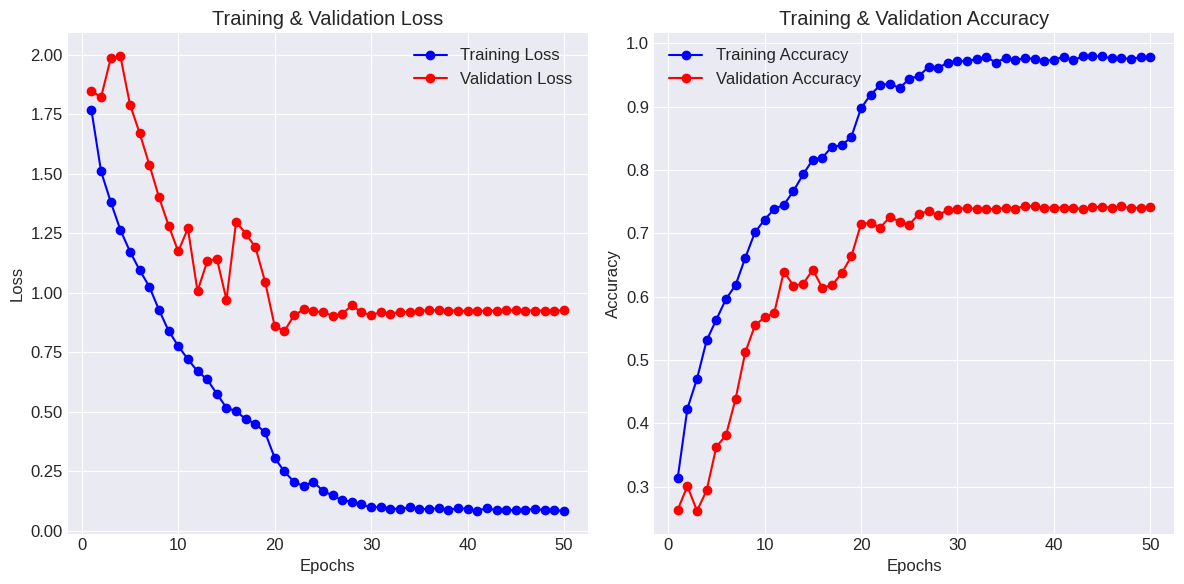

In [ ]:
plot_history(history_lstm)

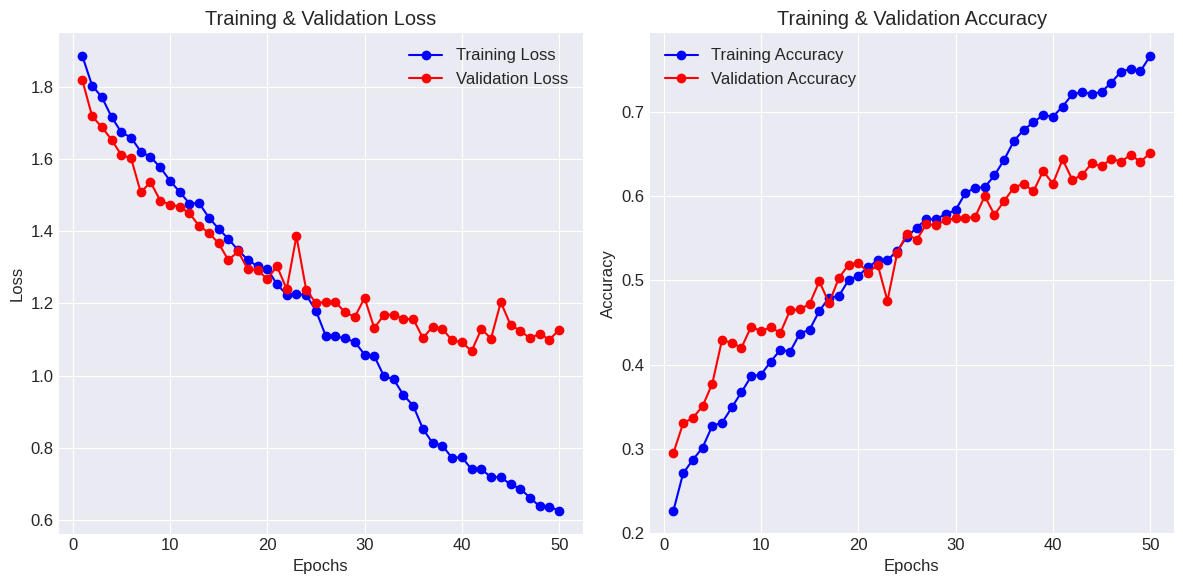

In [ ]:
plot_history(history_cnn)

In [ ]:
y_pred_lstm = np.argmax(model_lstm.predict(x_test_reshaped), axis=1)
y_pred_cnn = np.argmax(model_cnn.predict(x_test_reshaped), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

34/34 [==============================] - 1s 22ms/step


Tạo ra ma trận nhầm lần (Confusion Matrix) :
Ma trận này giúp:
 - Đánh giá hiệu suất mô hình.
 - Phát hiện các mẫu dữ liệu bị phân loại sai.
 - Tối ưu hóa mô hình.

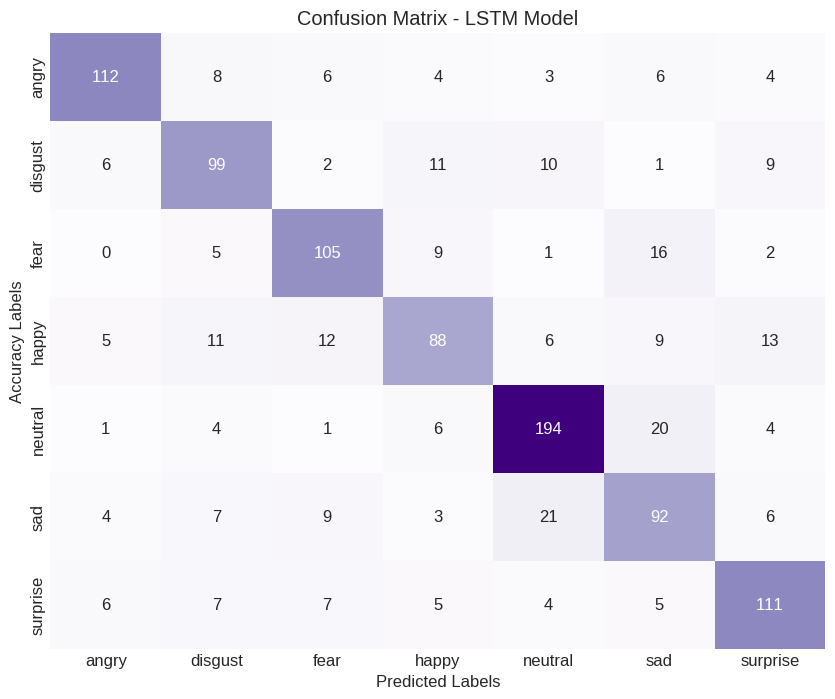

In [ ]:
# Tạo ma trận nhầm lẫn cho mô hình LSTM
# Tạo DataFrame từ ma trận nhầm lẫn với index và columns được đặt theo các nhãn từ encoder
cm_lstm = confusion_matrix(y_test_labels, y_pred_lstm)
cm_lstm_df = pd.DataFrame(cm_lstm, index=encoder.categories_[0], columns=encoder.categories_[0])

plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm_df, annot=True, cmap='Purples', fmt='d', cbar=False)
plt.title('Confusion Matrix - LSTM Model')
plt.xlabel('Predicted Labels')
plt.ylabel('Accuracy Labels')
plt.show()

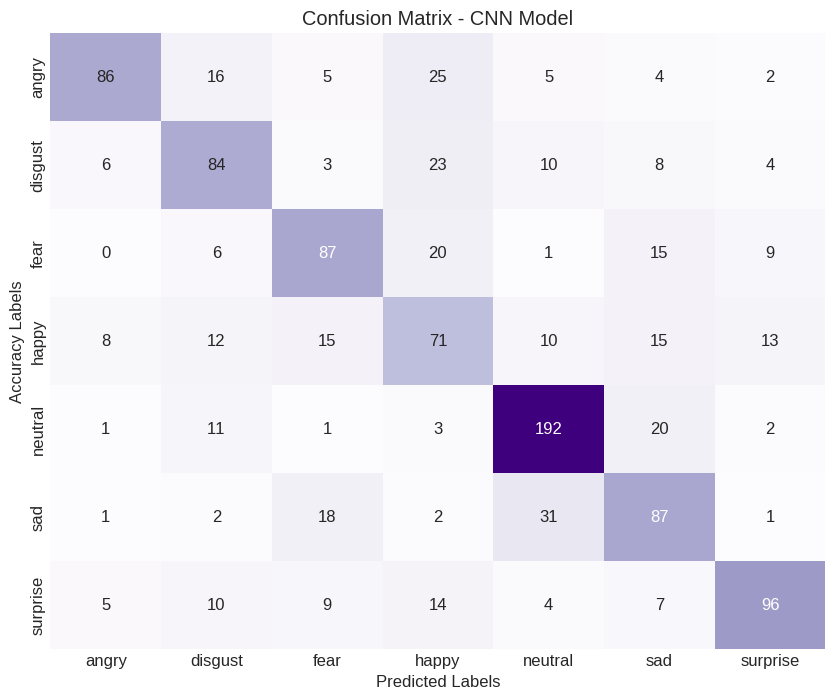

In [ ]:
# Tạo ma trận nhầm lẫn cho mô hình CNN
# Tạo DataFrame từ ma trận nhầm lẫn với index và columns được đặt theo các nhãn từ encoder
cm_cnn = confusion_matrix(y_test_labels, y_pred_cnn)
cm_cnn_df = pd.DataFrame(cm_cnn, index=encoder.categories_[0], columns=encoder.categories_[0])

plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn_df, annot=True, cmap='Purples', fmt='d', cbar=False)
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('Accuracy Labels')
plt.show()

In [ ]:
# Đánh giá hiệu suất của mô hình LSTM trên tập dữ liệu kiểm tra và in ra giá trị của loss và accuracy
loss_lstm, accuracy_lstm = model_lstm.evaluate(x_test_reshaped, y_test)
print("LSTM Model - Loss: {:.4f}, Accuracy: {:.2f}%".format(loss_lstm, accuracy_lstm * 100))

34/34 [==============================] - 0s 8ms/step - loss: 0.9259 - accuracy: 0.7417
LSTM Model - Loss: 0.9259, Accuracy: 74.17%


In [ ]:
# Đánh giá hiệu suất của mô hình CNN trên tập dữ liệu kiểm tra và in ra giá trị của loss và accuracy
loss_cnn, accuracy_cnn = model_cnn.evaluate(x_test_reshaped, y_test)
print("CNN Model - Loss: {:.4f}, Accuracy: {:.2f}%".format(loss_cnn, accuracy_cnn * 100))

34/34 [==============================] - 1s 22ms/step - loss: 1.1273 - accuracy: 0.6509
CNN Model - Loss: 1.1273, Accuracy: 65.09%


In [ ]:
# Chỉnh lại nhãn sau khi dự đoán từ số sang chữ
labels_mapping = {0: 'neutral', 1: 'happy', 2: 'sad', 3: 'angry', 4: 'fear', 5: 'disgust', 6: 'surprise'}

# Dự đoán nhãn từ chỉ số dự đoán của mô hình LSTM và CNN
y_pred_lstm_labels = [labels_mapping[idx] for idx in y_pred_lstm]
y_pred_cnn_labels = [labels_mapping[idx] for idx in y_pred_cnn]
y_test_labels = [labels_mapping[idx] for idx in y_test_labels]

In [ ]:
# Tạo và in ra báo cáo phân loại, so sánh giữa nhãn thực tế và nhãn dự đoán của mô hình LSTM
print("LSTM Model Classification Report:")
print(classification_report(y_test_labels, y_pred_lstm_labels))

LSTM Model Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.61      0.65       144
     disgust       0.62      0.65      0.63       142
        fear       0.81      0.84      0.83       230
       happy       0.70      0.72      0.71       138
     neutral       0.84      0.78      0.81       143
         sad       0.74      0.76      0.75       138
    surprise       0.74      0.77      0.76       145

    accuracy                           0.74      1080
   macro avg       0.74      0.73      0.73      1080
weighted avg       0.74      0.74      0.74      1080



In [ ]:
# Tạo và in ra báo cáo phân loại, so sánh giữa nhãn thực tế và nhãn dự đoán của mô hình CNN
print("CNN Model Classification Report:")
print(classification_report(y_test_labels, y_pred_cnn_labels))

CNN Model Classification Report:
              precision    recall  f1-score   support

       angry       0.45      0.49      0.47       144
     disgust       0.56      0.61      0.58       142
        fear       0.76      0.83      0.80       230
       happy       0.60      0.61      0.60       138
     neutral       0.80      0.60      0.69       143
         sad       0.63      0.63      0.63       138
    surprise       0.76      0.66      0.71       145

    accuracy                           0.65      1080
   macro avg       0.65      0.63      0.64      1080
weighted avg       0.66      0.65      0.65      1080

